# 3 - Aperture Photometry

# Aperture Photometry of a Single Object

## 1. Notebook Setup & Importation

In [1]:
%config InlineBackend.figure_format = 'retina'
%load_ext version_information
import time
now = time.strftime("%Y-%m-%d %H:%M:%S (%Z = GMT%z)")
print(f"This notebook was generated at {now} ")

vv = %version_information astropy, numpy, scipy, matplotlib, astroquery, ccdproc, photutils, ysfitsutilpy, ysphotutilpy, version_information
for i, pkg in enumerate(vv.packages):
    print(f"{i} {pkg[0]:10s} {pkg[1]:s}")

This notebook was generated at 2022-04-26 16:15:36 (KST = GMT+0900) 
0 Python     3.9.12 64bit [Clang 12.0.0 ]
1 IPython    7.31.1
2 OS         macOS 10.16 x86_64 i386 64bit
3 astropy    5.0.4
4 numpy      1.21.2
5 scipy      1.7.3
6 matplotlib 3.5.1
7 astroquery 0.4.7.dev7672
8 ccdproc    2.3.0
9 photutils  1.4.0
10 ysfitsutilpy 0.2.dev0
11 ysphotutilpy 0.0.2.dev0
12 version_information 1.0.4


In [2]:
import numpy as np
from pathlib import Path
from scipy.optimize import curve_fit
import warnings

from astropy.io import fits
from astropy.visualization import ZScaleInterval, ImageNormalize
from astropy.stats import sigma_clipped_stats
from astropy.nddata import Cutout2D
from astropy.modeling import models, fitting
from astropy.stats import gaussian_sigma_to_fwhm
from astropy.wcs import WCS
from astropy import units as u
from astropy.time import Time
from astropy.coordinates import SkyCoord

from astroquery.jplhorizons import Horizons

from photutils.aperture import CircularAperture as CAp
from photutils.aperture import CircularAnnulus as CAn
from photutils.centroids import centroid_com
from photutils import aperture_photometry as apphot
from photutils.detection import DAOStarFinder
from photutils.psf.groupstars import DAOGroup

from matplotlib import pyplot as plt
from matplotlib import rcParams
from matplotlib import patches
from matplotlib import gridspec

import ysvisutilpy as yvu
import ysfitsutilpy as yfu
import ysphotutilpy as ypu

warnings.filterwarnings('ignore', append=True, category=UserWarning)

DATAPATH = Path('../data/example')

In [3]:
# We need to do it in a separate cell. See:
# https://github.com/jupyter/notebook/issues/3385
plt.style.use('default')
rcParams.update({'font.size':12})

## 2. Loading and Cut Data
For FITS loading, please refer to the notebook on FITS file handing (02-Opening FITS).

Here, only the last line is added:
* Cut the image with [``astropy.nddata.Cutout2D``](https://docs.astropy.org/en/stable/api/astropy.nddata.utils.Cutout2D.html).
* I cut the image centered at ``position=(270, 320)`` and size of ``size=(100, 100)`` pixels. <- 이건 이미지보고 결정해야함

More tutorials on this module can be found at the official documentation on [image utilities](https://docs.astropy.org/en/stable/nddata/utils.html).

In [24]:
fpath = DATAPATH / 'ex_apphot.fits'

hdul = fits.open(fpath)
hdr = hdul[0].header
data = hdul[0].data
position, size = np.array([[385, 472], [70, 70]])
cut_hdu = Cutout2D(data=data, position=position, size=size)

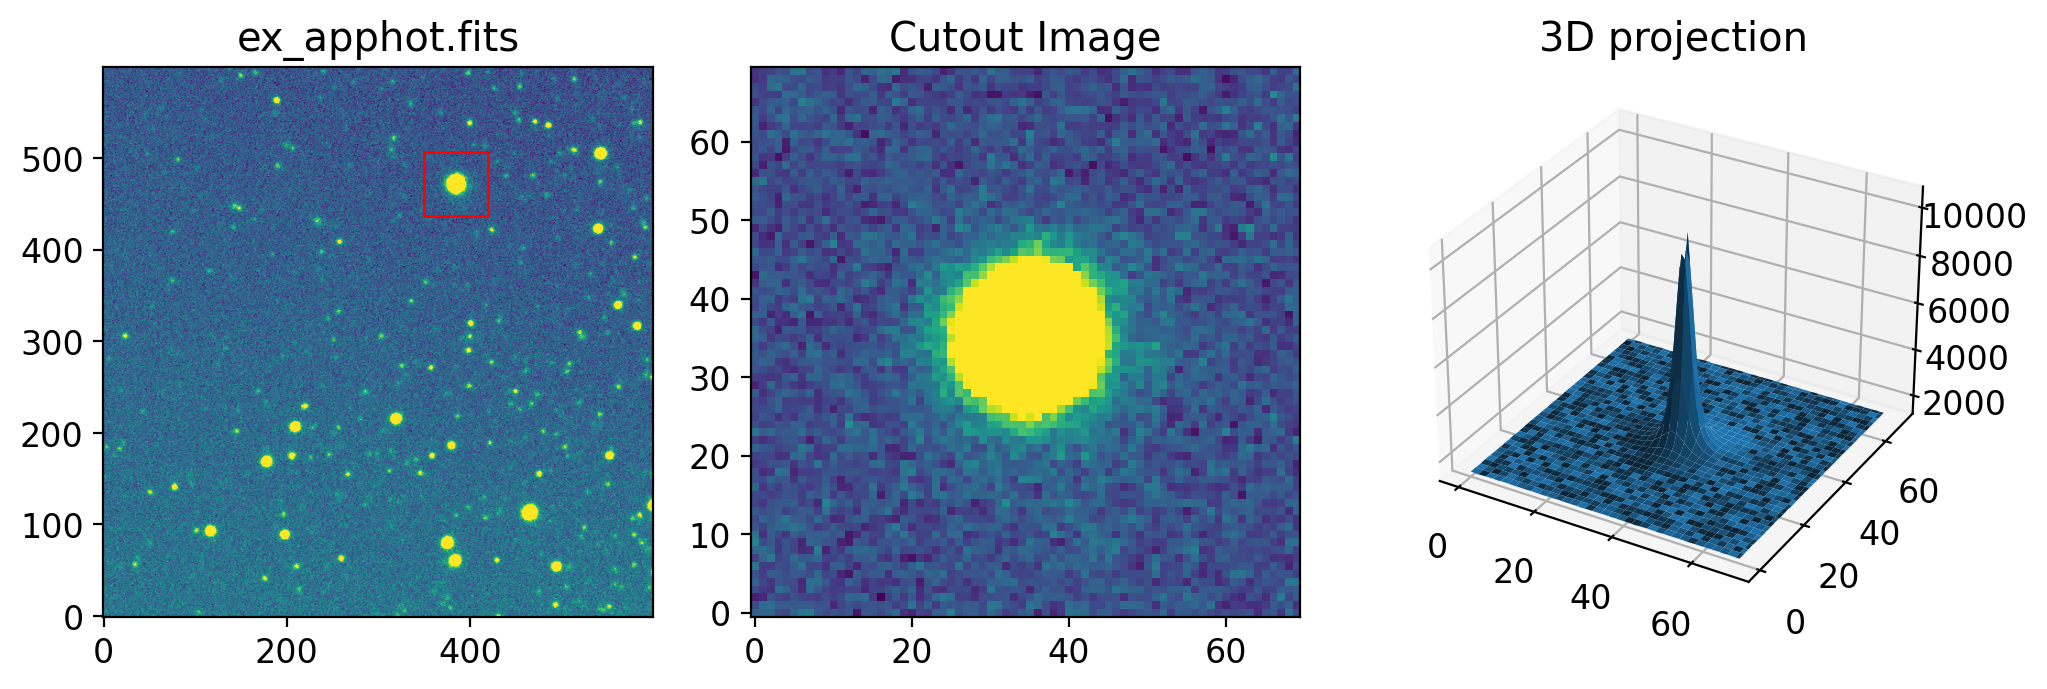

In [25]:
fig = plt.figure(figsize=(10, 4))
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133, projection='3d')
yvu.zimshow(ax1, data)
yvu.zimshow(ax2, cut_hdu.data)

n, m = cut_hdu.data.shape
x, y = np.mgrid[:n, :m]
ax3.plot_surface(x, y, cut_hdu.data)

# Create a Rectangle patch
rect = patches.Rectangle(position-size/2, *size, lw=1, ec='r', fc='none')
# Add the patch to the Axes
ax1.add_patch(rect)

ax1.set_title(fpath.name)
ax2.set_title('Cutout Image')
ax3.set_title('3D projection')
plt.tight_layout()

## 3. Finding Centroid
The center of mass from the image is calculated by [``photutils.centroids.centroid_com``](https://photutils.readthedocs.io/en/stable/api/photutils.centroids.centroid_com.html#photutils.centroids.centroid_com). For a bit more of the tutorial, visit official [``centroids`` documentation](https://photutils.readthedocs.io/en/stable/centroids.html). 

I did
* Do sigma-clipping to the cutout data. Get statistics of the clipped data.
* Set the threshold as median plus 3-sigma.
* Get centroid by center of mass algorithm using only the pixels above that threshold level.


In [26]:
avg, med, std = sigma_clipped_stats(cut_hdu.data)  # by default, 3-sigma 5-iteration.
thresh_3sig = med + 3 * std
mask_3sig = (cut_hdu.data < thresh_3sig)
center = centroid_com(data=cut_hdu.data, mask=mask_3sig)
print(center)

[34.92625762 35.01037454]


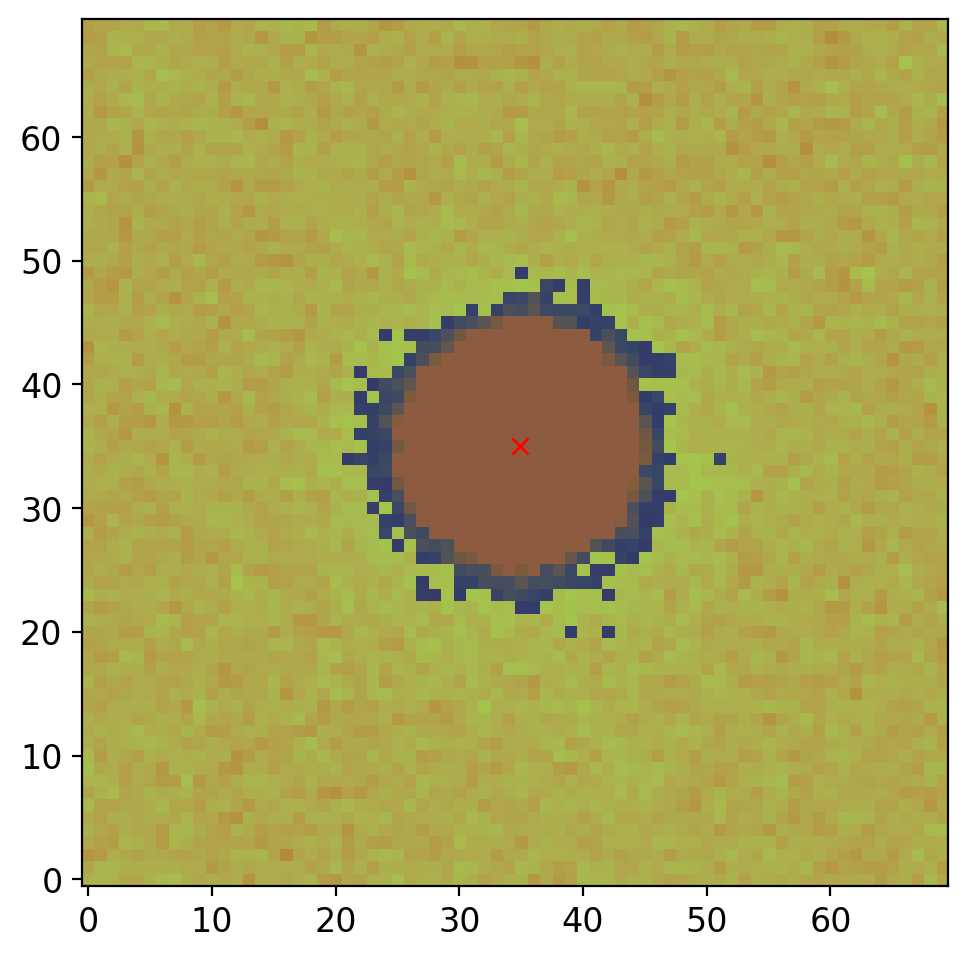

In [27]:
fig, axs = plt.subplots(1, 1, figsize=(5, 6))
yvu.zimshow(axs, mask_3sig.astype(int))
yvu.zimshow(axs, cut_hdu.data, alpha=0.4)
axs.plot(*center, 'rx')
plt.tight_layout()

* **TIP**: In realistic centroiding, this method **should not be used**. This is becasue virtually all of the photometric information is contained in only very small area around the true center, so we need to do centroiding using, e.g., cbox size of ~ 1-3 FWHM to minimize error sources. What you have to do is to cutout only a small region near the center of the object and do centroiding. This is not an easy task to realize, so it is better to use pre-made packages, such as ysphotutilpy.

## 4. Putting Aperture and Annulus

In [28]:
# fitting signal with 2D Gaussian function to obtain rough measurement of FWHM 
n, m = cut_hdu.data.shape
x, y = np.mgrid[:n, :m]
const_init = models.Const2D(amplitude=med)
g_init = models.Gaussian2D(amplitude=cut_hdu.data.max(), x_mean=n/2, y_mean=m/2,
                            x_stddev=10., y_stddev=10.)
f_init = const_init + g_init
fit_f = fitting.LevMarLSQFitter()
f = fit_f(f_init, x, y, cut_hdu.data)
x_fwhm = f.x_stddev_1.value*gaussian_sigma_to_fwhm
y_fwhm = f.y_stddev_1.value*gaussian_sigma_to_fwhm

print(f'x_stddev : {f.x_stddev_1.value}', f'y_sttddev : {f.y_stddev_1.value}')
print(f'conversion factor : {gaussian_sigma_to_fwhm}')
print(f'x_FWHM : {x_fwhm}', f'y_FWHM : {y_fwhm}')

fwhm = (x_fwhm + y_fwhm)/2
print(f'FWHM : {fwhm}')

x_stddev : 2.2110833173375517 y_sttddev : 2.2134164060633887
conversion factor : 2.3548200450309493
x_FWHM : 5.206703316899994 y_FWHM : 5.212197320998431
FWHM : 5.209450318949212


* From simple analysis, I found the FWHM of the point sources in the image is roughly 5 pixels. I will use this value throughout this note.
* I will set aperture radius to 1.5 FWHM $ \sim 2 \times 5 = 10$ pixels, and the inner and outer radii of annuli to be 4 and 6 FWHM, which are 20 and 30 pixels, respectively.

A good descriptive tutorial on using ``photutils`` for aperture photometry is given in the official documentation of the [aperture photometry](https://photutils.readthedocs.io/en/stable/aperture.html#local-background-subtraction). Here, I will do similar things but in a simpler way. If you have more than 1 star, you may need to look at the documentation and learn how to use for-loop effectively.

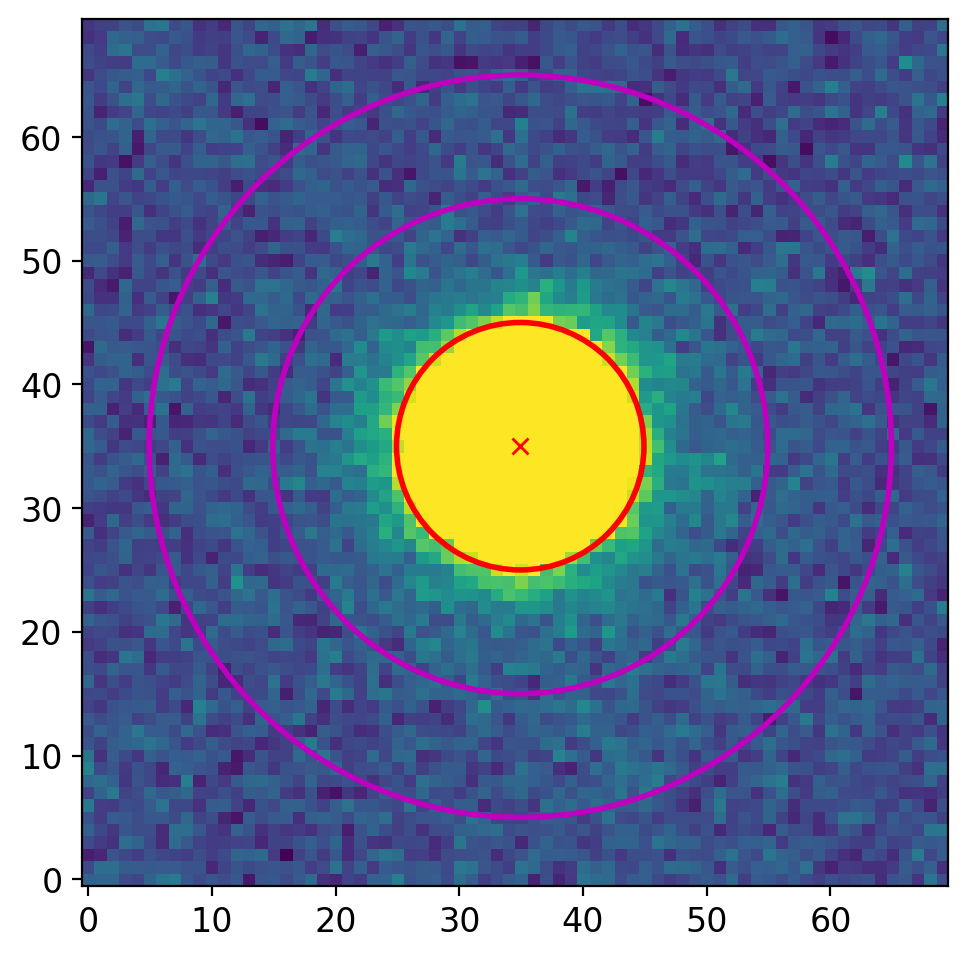

In [29]:
fwhm = 5
r_ap = 2 * fwhm
r_in = 4 * fwhm
r_out = 6 * fwhm
ap = CAp(positions=center, r=r_ap)
an = CAn(positions=center, r_in=r_in, r_out=r_out)

fig, axs = plt.subplots(1, 1, figsize=(5, 6))
yvu.zimshow(axs, cut_hdu.data)
ap.plot(axs, color='r', lw=2)
an.plot(axs, color='m', lw=2)
axs.plot(*center, 'rx')
plt.tight_layout()

## 5. Estimating Sky

As in the [aperture photometry](https://photutils.readthedocs.io/en/stable/aperture.html#local-background-subtraction) documentation, I here used the ``to_mask()`` method of the annulus object, and the ``.multiply`` method to extract the sky-region as ``sky_vals``.

Then I used the SExtractor sky estimation algorithm (see the Book chapter on SExtractor sky), showed crude histogram with estimated sky value.

Sky estimation: 1415.726 +- 5.662


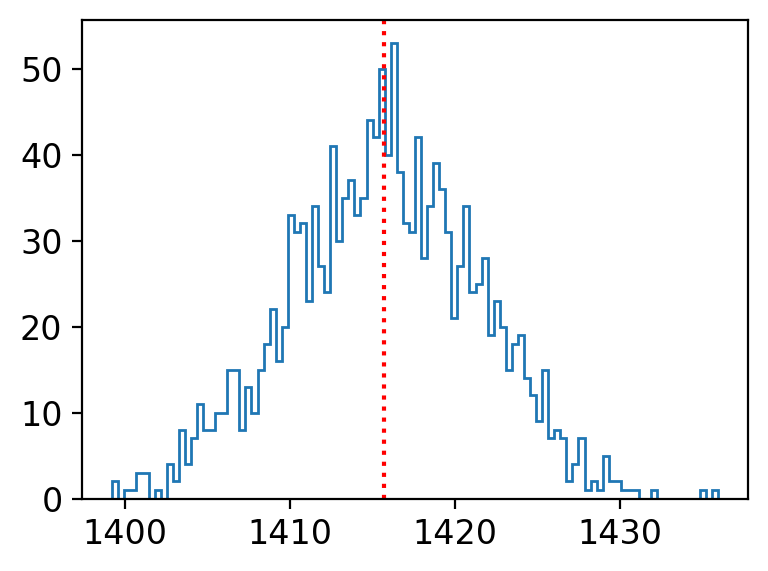

In [30]:
sky_mask = an.to_mask(method='center')
try:  # prior to photutils 0.7
    sky_vals = sky_mask[0].multiply(cut_hdu.data)
except TypeError:
    sky_vals = sky_mask.multiply(cut_hdu.data)
    
sky_vals = sky_vals[sky_vals > 0]
avg, med, std = sigma_clipped_stats(sky_vals, sigma=3, maxiters=10, std_ddof=1)

if med - avg < 0.3 * std:
    msky = med
else:
    msky = 2.5 * med - 1.5 * avg

print(f"Sky estimation: {msky:.3f} +- {std:.3f}")
    
fig, axs = plt.subplots(1, 1, figsize=(4, 3))

axs.hist(sky_vals, 100, histtype='step')
axs.axvline(msky, ls=':', color='r')
plt.tight_layout()

## 6. Do Photometry
Then we can do photometry using [``aperture_photometry``](https://photutils.readthedocs.io/en/stable/api/photutils.aperture_photometry.html#photutils.aperture_photometry) of ``photutils`` (I used the name ``apphot`` for short).

I here determined the sky, source sum ($ = \mathrm{aperture\_sum} - \mathrm{area}_\mathrm{aperture} \times \mathrm{sky}$), and the instrumental magnitude ($ = -2.5 \log_{10} \frac{\mathrm{source\_sum}}{t_\mathrm{exp}} $, where $ t_\mathrm{exp} $ is the exposure time in seconds)

In [31]:
phot = apphot(data=cut_hdu.data, apertures=ap)
phot["sky"] = msky
try:  # prior to photutils 0.7
    phot["source_sum"] = phot["aperture_sum"] - ap.area() * phot["sky"]
except TypeError:
    phot["source_sum"] = phot["aperture_sum"] - ap.area * phot["sky"]
    
phot["inst_mag"] = -2.5 * np.log10(phot["source_sum"] / hdr["EXPTIME"])
phot

id,xcenter,ycenter,aperture_sum,sky,source_sum,inst_mag
,pix,pix,,,,
int64,float64,float64,float64,float64,float64,float64
1,34.92625761939211,35.01037454139682,737547.166926604,1415.725830078125,292783.7801995291,-8.028186271648904


As a result, what you obtained are:
* Center of the object is (x, y) = (29.878, 30.128) pixel in the coordinate of the cutout image.
* Aperture sum is 737560 ADU, and the sky is estimated as 1415.725 ADU / pixel.
* The sky subtracted flux is 292797 ADU during the exposure time.
* The instrumental magnitude is -8.03 magnitude.

One missing thing here is the uncertainty of the values (e.g., $\Delta m$). This is a complicated topic, and I will distribute simplified package to do all the photometry with automatic error-calculation.

# Differential Photometry

Here I will demonstrate differential photometry for single-filter observation, which we have from KMTNet.

From [Note 3](https://nbviewer.jupyter.org/github/ysbach/AO2019/blob/master/Notebooks/03-Query.ipynb), we learnt how to query sidereal objects and the asteroid. In [Note 4](https://nbviewer.jupyter.org/github/ysbach/AO2019/blob/master/Notebooks/04-Aperture_Phot_01.ipynb), we learnt basics of aperture photometry.

Because many things can be tedious to learn and code, I here will use two packages:
* [``ysfitsutilpy`` package](https://github.com/ysBach/ysfitsutilpy): Convenience tools to manipulate FITS files
* [``ysphotutilpy`` package](https://github.com/ysBach/ysphotutilpy): Convenience tools for simple aperture photometry (PSF not supported yet)

**Please install these two.**

From next time, just do ``git pull && python setup.py install``.

Here, I will show how to perform aperture photometry to the given field.

## 2. Load Data

For details, please refer to [Note 03](https://nbviewer.jupyter.org/github/ysbach/AO2019/blob/master/Notebooks/03-Query.ipynb).

In [41]:
allfits = list(DATAPATH.glob("2018*.fits"))
allfits.sort()

hdul = fits.open(allfits[0])
hdr = hdul[0].header
data = hdul[0].data

# Set WCS and print for your information
hdr.rename_keyword('RADECSYS', 'RADESYSa')  # to avoid depreciation warning
w = WCS(hdr)

A summary information of the WCS information (for full information, try ``w.wcs``):

In [43]:
w

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 204.8640878996  -8.991494826739  
CRPIX : -4068.090526349  5085.76507007  
PC1_1 PC1_2  : -0.0001096993846665  -1.593373136163e-06  
PC2_1 PC2_2  : -2.91576786403e-07  0.0001095957848141  
CDELT : 1.0  1.0  
NAXIS : 999  999

## 3. Query Asteroid's Ephemerides

In [44]:
# Query object
objname = "4179"
observat = "B31"  # Observatory code: see https://en.wikipedia.org/wiki/List_of_observatory_codes
t_obs = Time(hdr["DATE-OBS"]) + hdr["EXPTIME"] * u.s / 2  # middle of observation time
obj = Horizons(id=objname, location=observat, epochs=t_obs.jd)
obj_q = obj.ephemerides()

pos_sky = SkyCoord(obj_q["RA"][0], obj_q["DEC"][0], unit='deg')
pos_pix = pos_sky.to_pixel(wcs=w)

The RA/DEC and the WCS-transformed position of the object in pixel unit:

In [45]:
pos_sky, pos_pix

(<SkyCoord (ICRS): (ra, dec) in deg
     (204.36166, -9.49665)>,
 (array(500.58291238), array(500.43561473)))

* **PRACTICE**: Look at the table ``obj_q``. What is the heliocentric and geocentric distance of the asteroid? See the [``astroquery.jplhorizons.HorizonsClass`` documentation](https://astroquery.readthedocs.io/en/latest/api/astroquery.jplhorizons.HorizonsClass.html#astroquery.jplhorizons.HorizonsClass) for help. You may want to look at the doc of ``.ephemerides()``.

## 4. Query Stars' Positions

Below, I used ``ypu.PanSTARRS1``, which accesses to VizieR for PS1 DR1 catalog. It is a "refined" version of the ``panstarrs_query`` in the previous notebook ([Note 3](https://nbviewer.jupyter.org/github/ysbach/SNU_AOclass/blob/master/Notebooks/03-Query.ipynb)).
If you are interested in all the details, please see the source code. 

I will query stars with g-magnitude 13-20 mag, and the error in the magnitude is smaller than 0.10 mag.

In [46]:
# Position of the telescope FOV center 
# (RA/DEC of the pixel at the center)
cent_coord = yfu.center_radec(header=hdr, center_of_image=True)

# Get the radius of the smallest circle which encloses all the pixels
rad = yfu.fov_radius(header=hdr, unit=u.deg)

# Initialize PanSTARRS1 class
q = ypu.PanSTARRS1(
    ra=cent_coord.ra.value, 
    dec=cent_coord.dec.value, 
    radius=rad,
    column_filters={"gmag":"13.0..20.0", "e_gmag":"<0.10"}
)


# Query to the website (VizieR)
# This is where the most of the time is spent.
q.query()

# Only select the stars within 50-pixel bezel in the FOV.
q.select_xyinFOV(header=hdr, bezel=50)

# Remove objects not suitable for differential photometry (see description below)
q.drop_for_diff_phot(drop_by_Kron=True)

# Remove redundant columns, remove objects with too few observations:
q.select_filters(filter_names=['g', 'r', 'i'], n_mins=5)
# You can try a list of ``n_mins``:
# q.select_filters(filter_names=['g', 'r', 'i'], n_mins=[10, 3, 5])

 23 objects remaining:   7 masked out of  30 based on [50 50]-pixel bezel.
 19 objects remaining:   4 masked out of  23 based on f_objID ([0, 1, 2, 3, 5, 7, 8, 9, 10, 23, 24]).
 19 objects remaining:   0 masked out of  19 based on the Kron magnitude criterion.
 19 objects remaining:   0 masked out of  19 based on o_['g', 'r', 'i']mag >= [5 5 5].


The ``.drop_for_diff_phot`` drops any object based on [**objinfoFlag**](https://outerspace.stsci.edu/display/PANSTARRS/PS1+Object+Flags). It removes any object which are likely variable star, QSO, transient, or extended (e.g., a galaxy or nebula). See the source code for details. 

The ``drop_by_Kron`` option is an empirical relation provided by PS1 ([here](https://outerspace.stsci.edu/display/PANSTARRS/How+to+separate+stars+and+galaxies)): If the ``imag`` - ``iKmag`` > 0.05, where ``imag`` is the PSF magnitude in i-band and ``iKmag`` is the Kron magnitude in i-band, it is likely a galaxy (only when ``imag < 21``). 

In [47]:
pos_stars_orig = q.queried.copy()
pos_stars_orig

_r,RAJ2000,DEJ2000,objID,f_objID,Ng,Nr,Ni,gPSFf,gmag,e_gmag,gmagStd,o_gmag,b_gmag,B_gmag,gKmag,e_gKmag,gFlags,rPSFf,rmag,e_rmag,rmagStd,o_rmag,b_rmag,B_rmag,rKmag,e_rKmag,rFlags,iPSFf,imag,e_imag,imagStd,o_imag,b_imag,B_imag,iKmag,e_iKmag,iFlags,x,y
deg,deg,deg,,,,,,,mag,mag,mag,,mag,mag,mag,mag,,,mag,mag,mag,,mag,mag,mag,mag,,,mag,mag,mag,,mag,mag,mag,mag,,,
float64,float64,float64,int64,int64,int16,int16,int16,float64,float64,float32,float64,int16,float64,float64,float64,float32,int32,float64,float64,float32,float64,int16,float64,float64,float64,float32,int32,float64,float64,float32,float64,int16,float64,float64,float64,float32,int32,float64,float64
0.013524,204.373110760,-9.504518530,96592043731934986,503635968,11,12,12,0.999663,18.9881,0.0052,0.0239,11,18.9313,19.0144,19.0234,0.0097,115000,0.999161,17.8156,0.0158,0.0667,9,17.7045,17.8609,17.8074,0.0127,115000,0.999666,16.3420,0.0047,0.0138,7,16.3199,16.3539,16.3543,0.0062,115000,398.854526619455,428.71480076890475
0.016672,204.377877590,-9.502094490,96592043779367867,436527104,13,17,13,0.999148,19.4660,0.0084,0.0339,11,19.4333,19.5316,19.5579,0.0171,115000,0.999569,19.4811,0.0160,0.1014,15,19.3019,19.7072,19.6090,0.0252,115000,0.999650,19.5663,0.0164,0.0741,13,19.4155,19.7006,19.6686,0.0206,115000,355.89106801169123,450.6317775770822
0.025932,204.341328520,-9.513024090,96582043413614797,503635968,10,12,16,0.999778,16.1395,0.0030,0.0080,9,16.1274,16.1512,16.1996,0.0029,115000,0.999632,15.5409,0.0033,0.0088,10,15.5292,15.5550,15.6203,0.0108,115000,0.999862,15.3048,0.0019,0.0111,10,15.2910,15.3247,15.3601,0.0036,115000,684.6504621153441,352.02715774649005
0.030195,204.376820280,-9.523144030,96572043768672650,503635968,12,15,11,0.999377,18.5533,0.0057,0.0201,12,18.5233,18.5856,18.5969,0.0099,115000,0.999674,17.9149,0.0108,0.0488,13,17.8302,17.9432,17.9166,0.0101,115000,0.999845,17.6055,0.0053,0.0353,8,17.5300,17.6289,17.6126,0.0132,115000,367.67794306328153,259.38182949074053
0.030473,204.350241240,-9.468566270,96632043502848177,436527104,11,17,13,0.999638,19.9052,0.0154,0.0499,10,19.8272,19.9870,19.9669,0.0295,115000,0.999704,19.5614,0.0107,0.0765,14,19.4328,19.7111,19.6166,0.0203,115000,0.999752,19.3970,0.0148,0.1498,11,19.0891,19.6205,19.4507,0.0690,16892216,599.8537514027679,755.6914642181437
0.032228,204.387235550,-9.517095530,96572043872939919,503635968,14,15,14,0.999669,16.2519,0.0021,0.0071,12,16.2390,16.2638,16.3135,0.0027,115000,0.999688,16.0229,0.0031,0.0094,11,16.0098,16.0353,16.0696,0.0053,115000,0.999616,15.9454,0.0032,0.0142,12,15.9134,15.9630,16.0086,0.0042,115000,273.7214362241896,314.13460705969646
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0.044746,204.395038360,-9.466305540,96642043950860865,503635968,15,13,14,0.999272,19.7648,0.0102,0.0416,14,19.6990,19.8201,19.8858,0.0220,115000,0.999789,18.6547,0.0061,0.0405,12,18.5726,18.7089,18.7366,0.0139,115000,0.999728,18.1301,0.0045,0.0296,13,18.0454,18.1601,18.2204,0.0058,115000,198.41841313970488,775.103637059221


The meaning of the columns can be found [here from VizieR](https://vizier.u-strasbg.fr/viz-bin/VizieR-2?-source=+II%2F349)

* **PRACTICE**: What is the type of ``pos_stars_orig``? Note the differences between astropy Table/QTable and pandas DataFrame. For your future, I recommend you familiarize yourselves with DataFrame, but here I will use astropy QTable, because it is one of the widely used formats in astronomical society for some reasonable reasons.

## 5. Star Matching

There are two ways to match the star you queried above with the object visible in the image.

1. You can find **star-like** objects in the image automatically. Then compare the positions of the stars you found from the image and the queried positions. 
2. Use the X Y coordinates from ``pos_stars`` above. Use it as the initial guess, crop the small portion (e.g., 7 by 7 pixel) of the image near the initial guess, and do centroiding at each position in the image iteratively until it converges.

Let me choose the first way in this note, because (1) the star-finding algorithm is a well-established one, (2) what it does is superior to the crude centroiding algorithm you may use in the second approach. The second way is a good choice to reduce the computation time if you have only few stars of interest in a large image.

Sometimes the second approach is not a good option. For example, if the queried star has a large proper motion (say it moved 10 arcsec from J2000 to the current epoch, say J2020.2) and the image has small pixel scale, say 0.5 arcsec per pixel, so that your star is away from the queried position by more than 20 pixels. Then if you chose the second approach, what you have as the cropped region (7 by 7 pixel) does not contain the star. Then the centroiding algorithm will result in an unrealistic result. 

Thus, an easier way to match the stars are
1. Query the stars (``q.queried`` above). _This is done above_.
2. Drop the stars with close distance, i.e., if there is any.
3. Find star-like objects in the image (say ``pos_found``).
4. Match the stars: find the closest stars between the table in #2 and ``pos_found`` (say ``pos_matched``).

There is ``photutils`` documentation on [detecting objects](https://photutils.readthedocs.io/en/stable/detection.html). Here I will use the [``DAOStarFinder`` module](https://photutils.readthedocs.io/en/stable/api/photutils.DAOStarFinder.html#photutils.DAOStarFinder), which is an implementation of the algorithm first developed by P. Stetson, and used extensively for the last 30-40 years by professional astronomers. This automatically finds the proper centroid of the stars, so we don't need any further centroiding process.

Here I used the following assumptions:
* From simple analysis, I found the FWHM of the point sources in the image is roughly 4 pixels. I will assume the seeing is fixed as 4 pixels.
* I will set aperture radius to 2 FWHM $ \sim 2 \times 4 = 8$ pixels, and the inner and outer radii of annuli to be 4 and 6 FWHM, which are 16 and 24 pixels, respectively. It means I am assuming that 6 pixels enoughly contains all the flux from the object, and the object does not affect pixels farther than 16 pixels away from its center.

### 5-1. Drop Nearby Stars

There are stars which are close to each other. These stars should not be used. I here will use ``q.drop_star_groups()``, which basically  uses [``DAOGroup`` of ``photutils``](https://photutils.readthedocs.io/en/stable/grouping.html). DAOGroup algoritm is an algorithm originally developed by P. Stetson in 1987.

The stars within ``crit_separation``, which I set as 6 times the FWHM (6 * 4 = 24 pixel), are regarded as "nearby stars" and grouped together. Any two or more stars grouped togeter will be removed.

In [48]:
fwhm = 4
q.drop_star_groups(crit_separation=6*fwhm)
pos_stars_dropped = q.queried.copy()  # This will be overridden: see below

 17 objects remaining:   2 masked out of  19 based on DAOGROUP with 24.000-pixel critical separation..


-----
-----
-----
### NOTE: The Simplest Way
Note that the identical process to get ``pos_stars`` can be done as below:

In [49]:
# Query sidereal objects (PS1)
cent_coord = yfu.center_radec(header=hdr, center_of_image=True)

rad = yfu.fov_radius(header=hdr, unit=u.deg)

# Initialize PanSTARRS1 class
ps1 = ypu.PanSTARRS1(
    ra=cent_coord.ra.value, 
    dec=cent_coord.dec.value, 
    radius=rad,
    column_filters={"gmag":"13.0..20.0", "e_gmag":"<0.10"}
)

_ = ypu.organize_ps1_and_isnear(
    ps1=ps1,
    header=hdr,
    bezel=50,
    group_crit_separation=6*fwhm,
    select_filter_kw=dict(filter_names=['g', 'r', 'i'], n_mins=5),
    drop_by_Kron=True,
    calc_JC=True  # This uses g-r color, so both g and r must not be removed.
)

 23 objects remaining:   7 masked out of  30 based on [50 50]-pixel bezel.
 21 objects remaining:   2 masked out of  23 based on DAOGROUP with 24.000-pixel critical separation..
 17 objects remaining:   4 masked out of  21 based on f_objID ([0, 1, 2, 3, 5, 7, 8, 9, 10, 23, 24]).
 17 objects remaining:   0 masked out of  17 based on the Kron magnitude criterion.
 17 objects remaining:   0 masked out of  17 based on o_['g', 'r', 'i']mag >= [5 5 5].


From ``calc_JC=True``, it calcualtes Johnson-Cousins B, V, and R magnitude of stars (based on Tonry J. et al. 2012, ApJ, 750, 99). Therefore, some new columns will have been added to ``ps1.queried``:
* ``grcolor``, ``e_grcolor``: g-r color and error ($ \sqrt{\mathtt{e\_gmag}^2 + \mathtt{e\_rmag}^2} $)
* ``<BVR>mag``, ``e_<BVR>mag``: B, V, and R mag and errors (Johnson-Cousins)

In [50]:
ps1.queried

_r,RAJ2000,DEJ2000,objID,f_objID,Ng,Nr,Ni,gPSFf,gmag,e_gmag,gmagStd,o_gmag,b_gmag,B_gmag,gKmag,e_gKmag,gFlags,rPSFf,rmag,e_rmag,rmagStd,o_rmag,b_rmag,B_rmag,rKmag,e_rKmag,rFlags,iPSFf,imag,e_imag,imagStd,o_imag,b_imag,B_imag,iKmag,e_iKmag,iFlags,x,y,grcolor,e_grcolor,Bmag,e_Bmag,Vmag,e_Vmag,Rmag,e_Rmag
arcsec,deg,deg,,,,,,,mag,mag,mag,,mag,mag,mag,mag,,,mag,mag,mag,,mag,mag,mag,mag,,,mag,mag,mag,,mag,mag,mag,mag,,,,mag,mag,mag,mag,mag,mag,mag,mag
float64,float64,float64,int64,int64,int16,int16,int16,float64,float64,float32,float64,int16,float64,float64,float64,float32,int32,float64,float64,float32,float64,int16,float64,float64,float64,float32,int32,float64,float64,float32,float64,int16,float64,float64,float64,float32,int32,float64,float64,float64,float32,float64,float32,float64,float32,float64,float32
48.686,204.373110760,-9.504518530,96592043731934986,503635968,11,12,12,0.999663,18.9881,0.0052,0.0239,11,18.9313,19.0144,19.0234,0.0097,115000,0.999161,17.8156,0.0158,0.0667,9,17.7045,17.8609,17.8074,0.0127,115000,0.999666,16.3420,0.0047,0.0138,7,16.3199,16.3539,16.3543,0.0062,115000,398.854526619455,428.71480076890475,1.1725,0.0166,19.8894,0.0354,18.3774,0.0144,17.5240,0.0152
60.019,204.377877590,-9.502094490,96592043779367867,436527104,13,17,13,0.999148,19.4660,0.0084,0.0339,11,19.4333,19.5316,19.5579,0.0171,115000,0.999569,19.4811,0.0160,0.1014,15,19.3019,19.7072,19.6090,0.0252,115000,0.999650,19.5663,0.0164,0.0741,13,19.4155,19.7006,19.6686,0.0206,115000,355.89106801169123,450.6317775770822,-0.0151,0.0181,19.6701,0.0356,19.4799,0.0147,19.3451,0.0152
93.355,204.341328520,-9.513024090,96582043413614797,503635968,10,12,16,0.999778,16.1395,0.0030,0.0080,9,16.1274,16.1512,16.1996,0.0029,115000,0.999632,15.5409,0.0033,0.0088,10,15.5292,15.5550,15.6203,0.0108,115000,0.999862,15.3048,0.0019,0.0111,10,15.2910,15.3247,15.3601,0.0036,115000,684.6504621153441,352.02715774649005,0.5986,0.0045,16.7039,0.0341,15.8306,0.0122,15.3245,0.0150
108.702,204.376820280,-9.523144030,96572043768672650,503635968,12,15,11,0.999377,18.5533,0.0057,0.0201,12,18.5233,18.5856,18.5969,0.0099,115000,0.999674,17.9149,0.0108,0.0488,13,17.8302,17.9432,17.9166,0.0101,115000,0.999845,17.6055,0.0053,0.0353,8,17.5300,17.6289,17.6126,0.0132,115000,367.67794306328153,259.38182949074053,0.6384,0.0122,19.1410,0.0347,18.2235,0.0133,17.6933,0.0151
109.703,204.350241240,-9.468566270,96632043502848177,436527104,11,17,13,0.999638,19.9052,0.0154,0.0499,10,19.8272,19.9870,19.9669,0.0295,115000,0.999704,19.5614,0.0107,0.0765,14,19.4328,19.7111,19.6166,0.0203,115000,0.999752,19.3970,0.0148,0.1498,11,19.0891,19.6205,19.4507,0.0690,16892216,599.8537514027679,755.6914642181437,0.3438,0.0188,20.3200,0.0357,19.7304,0.0149,19.3784,0.0152
116.021,204.387235550,-9.517095530,96572043872939919,503635968,14,15,14,0.999669,16.2519,0.0021,0.0071,12,16.2390,16.2638,16.3135,0.0027,115000,0.999688,16.0229,0.0031,0.0094,11,16.0098,16.0353,16.0696,0.0053,115000,0.999616,15.9454,0.0032,0.0142,12,15.9134,15.9630,16.0086,0.0042,115000,273.7214362241896,314.13460705969646,0.2290,0.0037,16.5993,0.0341,16.1374,0.0121,15.8549,0.0150
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145.674,204.360481080,-9.537250170,96552043605265732,436527104,10,12,15,0.999252,18.9182,0.0112,0.0390,8,18.8483,18.9764,19.0108,0.0138,115000,0.999140,18.6611,0.0173,0.0285,10,18.6078,18.6878,18.7330,0.0246,115000,0.999667,18.5390,0.0104,0.0869,13,18.4955,18.7252,18.6206,0.0132,115000,515.6790029104372,131.42145048078783,0.2571,0.0206,19.2821,0.0361,18.7890,0.0155,18.4894,0.0152


Since this is identical to the ``q.queried``, but with more information (B, V, R magnitudes), **let's defind ``pos_stars`` with this!**

In [51]:
pos_stars = ps1.queried.copy()

-----
-----
-----

Below I drew 
1. The originally queried stars by white circles.
2. The stars after "nearby-removal" by red circles.

In [52]:
ap_stars_orig = CAp(positions=(pos_stars_orig["x"], pos_stars_orig["y"]), r=15)
ap_stars = CAp(positions=(pos_stars["x"], pos_stars["y"]), r=20)

fig, axs = plt.subplots(1, 1, figsize=(5, 6), sharex=False, sharey=False, gridspec_kw=None)
yvu.norm_imshow(axs, hdul[0].data, zscale=True)
ap_stars_orig.plot(color='w', lw=2)
ap_stars.plot(color='r', lw=2)

axs.set_title("PS1 Query: Dropping Nearby Stars")
plt.tight_layout()

ValueError: Input positions must be an (x, y) pixel position or a list or array of (x, y) pixel positions, e.g., [(x1, y1), (x2, y2), (x3, y3)].

Note that the two stars at the right side are removed in the red colors, as they were too close.

### 5-2. Star Finder

The following code will find star-like objects in the FOV.

I set the threshold for the detection to be pixel-wise S/N ratio of roughly 5.

I did the same dropping nearby star process here too, because if the stars detected in the image are nearby, they must not be used. 

* **TIP**: Some may ask why this is necessary because we have already dropped nearby stars in previous step. In the previous step, we dropped nearby stars based solely on the catalogued positions. Some objects may be bright enough but not catalogued for some reason, so they are detected only by this star finding process. In unfortunate cases, such stars may be near to the star that we may have expected to be "isolated" from the nearby object removal in the above. What if we skip the above process but drop stars only based on the star finding algorithm? There might be faint object which were bright enough to be catalogued, but unfortunately unresolved in our image. Then as they are not distinguishable  in our image, our instrumental  magnitude will be the sum of the objects, while we will use the catalogue magnitude of only one of the overlapping stars. Thus, **the two processes are both necessary**.

In [ ]:
avg, med, std = sigma_clipped_stats(data) # default is 3-sigma, 5 iters
thresh = 5 * std
finder = DAOStarFinder(
    fwhm=4, threshold=thresh,   # In reality, FWHM must be measured a priori using, e.g., ``ginga``
    sharplo=0.2, sharphi=1.0,   # default values 0.2 and 1.0
    roundlo=-1.0, roundhi=1.0,  # default values -1 and +1
    sigma_radius=1.5,           # default values 1.5
    ratio=1.0,                  # 1.0: circular gaussian
    exclude_border=True         # To exclude sources near edges
)

# The DAOStarFinder object ``finder`` gets at least one input: the image.
# Then it returns the astropy table which contains the aperture photometry results:
found = finder(data)

# Use ``found`` for aperture photometry:
coords_SF = (found['xcentroid'], found['ycentroid'])
ap_found = CAp(coords_SF, r=25)  

# Plot all
fig, axs = plt.subplots(1, 1, figsize=(5, 6), sharex=False, sharey=False, gridspec_kw=None)
yvu.norm_imshow(axs, data, zscale=True)
ap_found.plot(color='k', lw=2, alpha=0.7)
ap_stars.plot(color='red', lw=2, alpha=0.7)

axs.set
plt.tight_layout()

* **PRACTICE**: Change ``roundlo=-1.0, roundhi=1.0``, to ``roundlo=-.5, roundhi=.5``, then see our object, at the center of image, is not detected from star finder. This happens _partly_ because the observation was made in non-sidereal tracking mode, i.e., the moving object (our asteroid) become slightly elliptical on the CCD (i.e., its ``round`` parameter gets larger). Note that some of the stars are undetected too.
* **PRACTICE**: Change parameters, such as ``sigma_radius`` to ``2``. The red star which is missed in the star finder will now be found.

### 5-3. Drop Stars with No Nearby Object in the Image

Now I want to select the "overlapping" stars. For each of the positions that we have obtained from the query, I will check whether there is a star from star-finding algorithm nearby it. If there is no such star nearby the queried XY position (say within 5 pixels), I will regard that queried position as unreliable position. This can happen, e.g., because the star is too faint to be imaged as star-like object in our observation. To do this, we have to initialize some of the columns. Then I calculated the "pixel shift", i.e., the distance between the queried and star-finding algorithm positions. This must be at most around 1 pixel order or smaller than seeing disc size.

In [ ]:
# Set the maximum allowable distance
match_distance = 5 # pixel

# Initialize some columns
for c in ["xcentroid", "ycentroid", "peak", "pixel_shift"]:
    pos_stars[c] = np.nan

for i, coo in enumerate(pos_stars):
    dx = np.abs(found['xcentroid'] - coo['x'])
    dy = np.abs(found['ycentroid'] - coo['y'])
    distances = np.sqrt(dx**2 + dy**2)
    accepted_SF = found[distances < match_distance]
    if len(accepted_SF) == 0:
        continue
    elif len(accepted_SF) > 1:
        raise ValueError(f"More than 1 star match for the {i}-th row!? Reduce match_distance.")
    else:
        pos_stars[i]["pixel_shift"] = distances.min()
        pos_stars[i]["xcentroid"] = found[distances.argmin()]["xcentroid"]
        pos_stars[i]["ycentroid"] = found[distances.argmin()]["ycentroid"]
        pos_stars[i]["peak"] = found[distances.argmin()]["peak"]

# Select only those which are matched
matched = pos_stars[pos_stars["pixel_shift"] < match_distance]
matched

As can be seen, there are now 16 stars that can be used. Before the dropping, there were 17 stars in ``pos_stars``, so one star is removed.

Note ``pixel_shift`` is at most only about 1 pixel.

* **PRACTICE**: Increase ``match_distance`` to, e.g., 100. What happens?
* **PRACTICE**: Explain how the matching has been done in the above. Can you make it more efficient?
* **PRACTICE**: Can you see which is that removed star? Find an object with red circle but no black circle in the previous figure.

## 6. Aperture Photometry

The idea of photometry is not that difficult. The tricky part is to realize that calculation in computer. How can we calculate the pixel sum for non-rectangular aperture (e.g., circle)? How can I chop the *sky regions* from the CCD image? Things should have been easier in theoretical approach, but it gets extremely tricky and difficult for those who are not so accustomed to programming (including myself). Here, I will use a simple personal package that I use from time to time, and just show the results, because you all now know how those are calculated.

In [ ]:
ccd = yfu.load_ccd(path=allfits[0])
err = yfu.make_errmap(ccd=ccd, gain_epadu=hdr["GAIN"], rdnoise_electron=hdr["RDNOISE"])

Although you should do a more careful calculation, I here will use the star-finder algorithm's resulting object position as the image center of our target. There is only one single such object for `498 < xcentroid < 502` and `498 < ycentroid < 502`:

In [ ]:
found_targ = found[(498 < found["xcentroid"]) & (found["xcentroid"] < 502)
                   & (498 < found["ycentroid"]) & (found["ycentroid"] < 502)]
found_targ

In [ ]:
pos_star_match = (matched["xcentroid"], matched["ycentroid"])
pos_targ = (found_targ["xcentroid"], found_targ["ycentroid"])

fwhm = 4
r_ap = 2*fwhm
r_in = 4*fwhm
r_out = 6*fwhm

star_ap = CAp(positions=pos_star_match, r=r_ap)
star_an = CAn(positions=pos_star_match, r_in=r_in, r_out=r_out)

targ_ap = CAp(positions=pos_targ, r=r_ap)
targ_an = CAn(positions=pos_targ, r_in=r_in, r_out=r_out)

phot_star = ypu.apphot_annulus(ccd=ccd,
                               aperture=star_ap,
                               annulus=star_an,
                               error=err)

phot_targ = ypu.apphot_annulus(ccd=ccd,
                               aperture=targ_ap,
                               annulus=targ_an,
                               error=err)

Plotting the position of stars and target, with the used apertures and annuli:

In [ ]:
fig, axs = plt.subplots(1, 1, figsize=(8, 8), 
                        sharex=False, sharey=False, gridspec_kw=None)
yvu.norm_imshow(axs, ccd, zscale=True)
star_ap.plot(axs, color='w')
star_an.plot(axs, color='r')
targ_ap.plot(axs, color='r')
targ_an.plot(axs, color='y')

# inset axes....
axins = axs.inset_axes([0.6, 0.4, 0.3, 0.3])
yvu.norm_imshow(axins, ccd, zscale=True)
# sub region of the original image
x1, x2, y1, y2 = 450, 550, 450, 550
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
axins.set_xticklabels('')
axins.set_yticklabels('')
targ_ap.plot(axins, color='r')
targ_an.plot(axins, color='y')
axs.indicate_inset_zoom(axins, edgecolor='r')

plt.tight_layout()
fig.align_ylabels(axs)
fig.align_xlabels(axs)
plt.show()

In [ ]:
# Photometry result of the target:
phot_targ

* ``aperture_sum`` is ~17254.9 (ADU)
* sky value ``msky`` is ~81.747 (ADU/pix) 
* aperture area ``aparea`` of ~201.06 pixels (strictly, pix^2), 
* so source count is ``17254.9 - 201.06*81.747 ~ 818`` (as in the ``source_sum``). 
* The instrumental mag is ``-2.5 * log10(source_sum) ~ -2.8 mag`` as in ``mag``.
* The error-bar is calculated from (1) Poisson noise, (2) readout noise, (3) sky-estimation uncertainty, and is 0.23 mag, i.e., ~ 20% uncertainty.

In [ ]:
# photometry of stars
phot_star

## 7. Getting Standardized Magnitude of the Asteroid

### 7-1. Review

As we have learnt in the lecture, we have
$$ M_f = m_f - k_f' X - k_f''XC + z_f + k_f C \equiv Z_f + m_f $$
* $ f $: The filter (V, B, g', etc).
* $ X $: airmass (secant of zenith angle).
* $ M_f $: The standard apparent magnitude (or the true apparent magnitude) at filter $ f $.
* $ m_f $: The instrumental magnitude, i.e., $ -2.5 \log_{10} N $.
* $ C $: The true color index, e.g., $ \mathrm{B} - \mathrm{V} $ or $ \mathrm{r'} - \mathrm{i'} $.
* $ k_f' $: The first order extinction coefficient at filter $ f $.
* $ k_f'' $: The second order extinction coefficient at filter $ f $.
* $ z_f $: The zero point at filter $ f $.
* $ k_f $: The system transform coefficient.

### 7-2. Finding Z

As noted in the seminar, all the terms other than $m_f$ in the RHS ($Z_f$) are sometimes collectively called the *zero point*. But I always use *zero point* for $z_f$, and do not coin any term for $Z_f$.  

What we first have to do:
1. Check the linearity curve
2. Check if $Z_f$ has any color dependency.

Note that we have observed in V-filter, so we have to use the V-magnitude of the catalogue (PS1 DR1).

In [ ]:
def linf(x, a, b):
    return a*x + b

fig = plt.figure(figsize=(12, 6))
gs = gridspec.GridSpec(3, 3)
# NOTE: Z = R - R_inst = zp + 1st ext
ax_l = fig.add_subplot(gs[:2, 0])                # Linearity plot
ax_r = fig.add_subplot(gs[2, 0], sharex=ax_l)    # residual plot
ax_c = fig.add_subplot(gs[:, 1:])                # C(g-r) VS Z plot
errbfmt = dict(marker='x', ls='', capsize=5, elinewidth=0.5)

m_true = matched["Vmag"]
m_inst = phot_star["mag"]
e_m_true = matched["e_Vmag"]
e_m_inst = phot_star["merr"]
color = matched["grcolor"]
e_color = matched["e_grcolor"]
Z = m_true - m_inst
e_Z = np.sqrt(e_m_true**2 + e_m_inst**2)
s_Z = np.std(Z, ddof=1)  # standard deviation
m_Z = np.mean(Z)         # Simple mean
Z_fit = np.average(Z, weights=(1/e_Z**2))
e_Z_fit = np.sqrt(1 / np.sum(1/e_Z**2))

mm = np.linspace(m_true.min(), m_true.max(), 2)  # grid
cc = np.linspace(color.min(), color.max(), 2)  # grid
p_ll, _ = curve_fit(linf, m_true, m_inst, sigma=e_m_inst, absolute_sigma=True)
p_cz, _ = curve_fit(linf, color, Z, sigma=e_Z, absolute_sigma=True)

ax_l.errorbar(m_true, m_inst, xerr=e_m_true, yerr=e_m_inst, **errbfmt)
ax_l.plot(mm, linf(mm, *p_ll), 'k-', label=f"y={p_ll[0]:.4f}x + {-p_ll[1]:.3f}")
ax_l.plot(mm, mm - Z_fit, 'r-', label=f"y=x + {Z_fit:.3f} (see right)")
ax_l.set(ylabel="V$_\mathrm{inst}$", title="Linearity Curve")
ax_l.legend(loc=2, framealpha=0, fontsize=10)
for j, (x_i, y_i) in enumerate(zip(m_true, m_inst)):
    ax_l.text(x=x_i+0.1, y=y_i-0.1, s=j+1)
    
ax_r.errorbar(m_true, Z, yerr=e_Z, **errbfmt)
ax_r.axhline(Z_fit, color='r', ls='-', lw=1)
ax_r.axhline(Z_fit + e_Z_fit, color='r', ls='--', lw=1, label=None) 
ax_r.axhline(Z_fit - e_Z_fit, color='r', ls='--', lw=1, label=None)
ax_r.axhline(m_Z + s_Z, color='b', ls=':', lw=1, label=None) 
ax_r.axhline(m_Z - s_Z, color='b', ls=':', lw=1, label=None)
ax_r.set(xlabel="V from PS1 g/r (Tonry+ 2012)",
         ylabel="V - V$_\mathrm{inst}$",
         ylim=(m_Z - 5*s_Z, m_Z + 5*s_Z)
        )
for j, (x_i, y_i) in enumerate(zip(m_true, Z)):
    ax_r.text(x=x_i, y=y_i, s=j+1)

ax_c.errorbar(color, Z, yerr=e_Z, xerr=e_color, **errbfmt)
ax_c.axhline(Z_fit, color='r', ls='-', lw=1, label=f"wieghted avg = {Z_fit:.3f}")
ax_c.axhline(Z_fit + e_Z_fit, color='r', ls='--', lw=1, label=f"err = {e_Z_fit:.3f}") 
ax_c.axhline(Z_fit - e_Z_fit, color='r', ls='--', lw=1, label=None)
ax_c.axhline(m_Z, color='b', ls='-', lw=1, label=f"simple avg = {m_Z:.3f}")
ax_c.axhline(m_Z + s_Z, color='b', ls=':', lw=1, label=f"std = {s_Z:.3f}") 
ax_c.axhline(m_Z - s_Z, color='b', ls=':', lw=1, label=None)
ax_c.plot(cc, linf(cc, *p_cz), 'k-')
ax_c.legend(loc=2, framealpha=0, ncol=2)
ax_c.set(xlabel="g - r from PS1",
         title="Z = V - V$_\mathrm{inst}$ = (k + k''X)C + (zero + k'X)")

ax_c2 = ax_c.twinx()
ax_c2.plot(np.nan, np.nan, 'k-',
           label=f"y={p_cz[0]:.3f}x + {p_cz[1]:.3f}")
ax_c2.legend(loc=4)
ax_c2.axis('off')

for j, (x_i, y_i) in enumerate(zip(color, Z)):
    ax_c.text(x=x_i, y=y_i, s=j+1)

yvu.linticker(
    [ax_l, ax_r, ax_c],
    xmajlockws=[1  , 1  , 0.2],
    xminlockws=[0.2, 0.2, 0.1],
    ymajlockws=[1  , 0.2, 0.1],
    yminlockws=[0.2, 0.1, 0.05]
)

plt.tight_layout()

# fig, zp_fit, dzp_fit, mzp, szp, linSlope, zpSlope = zpplot(matched, phot_star)

1. The linearity curve looks quite linear, in that the fitted linear line has a slope of 1.005 ~ 1.0.
2. The residual plot shows the scatter gets larger for fainter object, as expected. Note that the star #6 deviated much, most likely because it is too faint and subjected to larger uncertainty.
3. The color plot shows no clear trend of the ``Z`` value against the g-r color (slope ~ 0.025). As we cover the color of range ~ 0 to ~1.2, we conclude that we can safely ignore any color effect within the accuracy we want.
    * **NOTE**: The uncertainty that will arise due to the color term will be ~ ``0.025*0.5 ~ 0.01`` mag, assuming the ± 0.5 mag of color uncertainty of our object. If we are not interested in the absolute value of the magnitude, this is nothing but a universal constant over the FITS files, so the *shape* of the light curve will not be affected though.

Here, I used [weighted mean with variance weighting](https://en.wikipedia.org/wiki/Weighted_arithmetic_mean#Variance_weights)
to find $ Z_f $ (in this case, we are using V filter so $ Z_\mathrm{V} $). If we have data of $ x_i \pm \sigma_i $ which are all normally distributed, then the weighted mean and its uncertainty are
$$ \bar{x} = \frac{\sum_i x_i / \sigma_i^2}{\sum_i 1 / \sigma_i^2} 
\quad;\quad
\sigma_{\bar{x}} = \frac{1}{\sqrt{\sum_i 1 / \sigma_i^2} }
$$
The weighted-mean of variance weight is widely used because it is *the* solution of the chi-square minimization (least square) technique, for Gaussian errors. In otherwords, this is the least-square fitting solution of a *constant function* to the data.

As we calculated $ \Delta \mathrm{V} $ above, I used error propagation to $ M_f - m_f $ term: $ \sqrt{(\Delta M_f)^2 + (\Delta m_f)^2} $, and this is the $ \sigma_i $.

From the color plot, we see that the weighted mean estimation (red) is much closer to the small-error-bar data points with smaller uncertainty than that without weighting (blue). This is because most of the widely scattered data points are those with large error-bar, so weighting scheme gives *penalty* to those points to shrink the confidence interval and makes the mean closer to the small-error-bar data and shrink its uncertainty. Statistically speaking, we should use the weighted result.

I calculated $Z$ values with at least 3 ways:

1. When linearity curve slope is a free parameter, $Z = 23.644$
2. When linearity curve slope is fixed (1), $Z = 23.546$; mathematically identical to get the weighted mean of $m - M$ values.
3. A simple average of $m - M$ values, $Z = 23.530$.

The first is not reasonable because we want to believe the linearity of CCD (slope = 1). As the fitting result shows slope ~ 1, it is better to reduce the degree of freedom and fix the slope to 1. The third does not take the uncertainty of fainter objects into account, so is not the best option. The second is the best I can think of. Fortunately, the last two results are almost similar (0.016 mag difference).

## 8. Results

In [ ]:
phot_targ["mstd"] = phot_targ["mag"] + Z_fit
phot_targ["mstd_err"] = np.sqrt(phot_targ["merr"]**2 + e_Z_fit**2)

tab = phot_targ.to_pandas()
tab.round(3)

You can see that the standardized magnitude is obtained as 20.709 and error is 0.234 magnitudes. Note that the error is not much increased before/after zero-point calculation. This is because we used confidence interval of the **mean** using weighted mean scheme. As we learnt in the class, this considers the interval of mean, not each individual observation (remember the coin-tossing experiment).

In the publication (Bach, Ishiguro, Jin et al. 2019, JKAS), we **WCS stacked** the images to increase the signal-to-noise ratio.
